In [1]:
%pylab inline
from tinygrad.tensor import Tensor
from tinygrad.nn import Linear
from tinygrad.nn.optim import Adam
from extra.utils import get_parameters
from tqdm import trange
import gym

# critic loss from:
# https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
try:
  env.close()
except Exception:
  pass
env = gym.make("CartPole-v1")
num_inputs, num_actions = env.observation_space.shape[0], env.action_space.n

# global memory from the VPG/SAC learning
memory = []
Tensor.no_grad = True

In [3]:
# random helpers
def to_one_hot(x,n):
  ret = np.zeros((len(x), n))
  ret[range(len(x)), x] = 1
  return ret

def reward_to_go(rews):
  n = len(rews)
  rtgs = np.zeros_like(rews)
  for i in reversed(range(n)):
    rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
  return rtgs

# global params
BS = 256       # note: VPG is always one episode, this is for Q-learning and SAC
ALPHA = 0.2    # entropy
GAMMA = 0.99   # discount (converges to Q=100 with 1 reward each time)
TAU = 0.005    # update

In [4]:
# Actor
class Policy:
  def __init__(self, num_inputs, num_actions):
    self.w1 = Linear(num_inputs, 32)
    self.w2 = Linear(32, num_actions)
  def __call__(self, x:Tensor):
    return x.sequential([self.w1, Tensor.tanh, self.w2])
  def sample(self, obs):
    obs = obs if isinstance(obs, Tensor) else Tensor(obs)
    act_distribution = self(obs).softmax()
    act_distribution_numpy = act_distribution.numpy()
    if len(act_distribution_numpy.shape) == 2:
      act = [np.random.choice(2, p=act_distribution_numpy[i]) for i in range(act_distribution_numpy.shape[0])]
    else:
      act = np.random.choice(2, p=act_distribution_numpy)
    return act, act_distribution

policy = Policy(num_inputs, num_actions)
policy_opt = Adam(get_parameters(policy), lr=1e-2)
env_steps = []
env_losses = []
ep_lens, ep_rews, ep_loss = [], [], []

In [5]:
# Critic
class QNetwork:
  def __init__(self, num_inputs, num_actions):
    self.w1 = Linear(num_inputs+num_actions, 32)
    self.w2 = Linear(32, 32)
    self.w3 = Linear(32, 1)
  def __call__(self, x:Tensor):
    return x.sequential([self.w1, Tensor.relu, self.w2, Tensor.relu, self.w3])

# init q network
q1 = QNetwork(num_inputs, num_actions)
q2 = QNetwork(num_inputs, num_actions)
q1s = QNetwork(num_inputs, num_actions)
q2s = QNetwork(num_inputs, num_actions)

hard_params = get_parameters(q1) + get_parameters(q2)
soft_params = get_parameters(q1s) + get_parameters(q2s)

# is assign okay to use here? +0 should at least make a copy
for x,y in zip(hard_params, soft_params): y.assign(x+0)

q_opt = Adam(get_parameters(q1) + get_parameters(q2), lr=1e-2)
q_losses = []

def learn_q_function(samples):
  s = [x[0] for x in samples]
  a = [x[1] for x in samples]
  sa = Tensor(s).cat(Tensor(to_one_hot(a, 2)), dim=1)
  r = [x[2] for x in samples]
  mask = [int(not x[3]) for x in samples]   # if it's the last step, mask the recursive Q
  ns = [x[4] for x in samples]

  na, _ = policy.sample(ns)
  nsa = Tensor(ns).cat(Tensor(to_one_hot(na, 2)), dim=1)
  q1_next, q2_next = q1s(nsa), q2s(nsa)  # max over both actions?
  next_value = Tensor.cat(q1_next, q2_next, dim=1).min(axis=1)
  next_q_value = Tensor(r) + GAMMA * next_value * Tensor(mask)
  next_q_value = next_q_value.reshape(-1, 1)

  # update the Q functions
  Tensor.no_grad = False
  q1_t, q2_t = q1(sa), q2(sa)
  q1_loss = ((q1_t - next_q_value)**2).mean()
  q2_loss = ((q2_t - next_q_value)**2).mean()
  q_loss = q1_loss + q2_loss
  q_opt.zero_grad()
  q_loss.backward()
  q_opt.step()
  Tensor.no_grad = True
  
  # update soft params
  for x,y in zip(hard_params, soft_params): y.assign((1-TAU)*y + TAU*x)
  
  return q_loss.numpy()[0]

In [ ]:
# VPG with entropy

# by 100 steps it starts to learn
for episode in (t:=trange(300)):
  # play an episode
  obs, done = env.reset(), False
  X,Y,rews = [], [], []
  episode_steps = 0
  while not done:
    act_distribution = policy(Tensor(obs)).softmax().numpy()
    ent = -sum(act_distribution * np.log2(act_distribution))
    act = np.random.choice(2, p=act_distribution)
    X.append(obs)
    Y.append(act)
    next_obs, rew, done, _ = env.step(act)
    
    episode_steps += 1
    if done and episode_steps < env._max_episode_steps: rew = -10.0
    rews.append(rew + ALPHA * ent)
    
    memory.append((obs, act, rew, done, next_obs))
    obs = next_obs
    #print(obs, rew, done)
  
  tmp = np.zeros((len(Y), 2))
  tmp[range(len(Y)), Y] = reward_to_go(rews)
  
  # learn the policy
  Tensor.no_grad = False
  policy_loss = -(policy(Tensor(X)).logsoftmax() * Tensor(tmp)).mean()
  policy_opt.zero_grad()
  policy_loss.backward()
  policy_opt.step()
  Tensor.no_grad = True
  
  t.set_description(f"{len(rews)} steps {policy_loss.numpy()[0]:.4f}")
  
  #print(loss.numpy(), len(rews))
  ep_lens.append(len(rews))
  ep_rews.append(sum(rews))
  ep_loss.append(policy_loss.numpy()[0])
plot(ep_lens)
plot(ep_rews)
figure()
plot(ep_loss)

In [ ]:
# learn Q function (soft + double Q)
# this is learned offline on the memory from the VPG training

for i in trange(300):
  idxs = [random.choice(len(memory)) for i in range(BS)]
  samples = [memory[x] for x in idxs]
  q_loss = learn_q_function(samples)
  q_losses.append(q_loss)

plot(q_losses)

In [ ]:
# Did the Q function learn?

pts_x, pts_y = [], []
rs, qs = [], []
for s,a,r,done,ns in memory[::len(memory)//1000]:
  pts_x.append(s[2])
  pts_y.append(s[3])
  rs.append(r)
  # max of the Q function is the value, right?
  qs.append(max(q1(Tensor(list(s)+[1,0])).numpy()[0], q1(Tensor(list(s)+[0,1])).numpy()[0]))
plt.scatter(pts_x, pts_y, s=np.array(rs)*-1)
figure()
plt.scatter(pts_x, pts_y, s=np.array(qs)*-1, c='red')

In [ ]:
# How do the functions look with numbers?

def debug(s):
  return q1(Tensor(s+[1,0])).numpy()[0], q1(Tensor(s+[0,1])).numpy()[0], policy(Tensor(s)).softmax().numpy()

for x in np.arange(-0.6,0.7,0.1):
  print(f"{x:.2f}",debug([0,0,x,0]))

In [ ]:
# run cartpole, with either policy or Q function
# both complete the full 500 steps (using argmax, not sampling)
Tensor.no_grad = True
obs, done = env.reset(), False
act_policy = []
act_q = []
episode_steps = 0
while not done:
  # policy
  act_distribution = policy(Tensor(obs)).numpy()
  act_policy.append(act_distribution)
  
  # Q function
  q_distribution = [min(q1(Tensor(list(obs)+[1,0])).numpy()[0], q2(Tensor(list(obs)+[1,0])).numpy()[0]), min(q1(Tensor(list(obs)+[0,1])).numpy()[0], q2(Tensor(list(obs)+[0,1])).numpy()[0])]
  act_q.append(q_distribution)
  
  # use the policy or the Q function to act?
  act = np.argmax(act_distribution)
  #act = np.argmax(q_distribution)
  
  obs, rew, done, _ = env.step(act)
  episode_steps += 1
  env.render()
plot(act_policy)
plot(np.array(act_q)[:, 1] - np.array(act_q)[:, 0])
figure()
plot(act_q)
episode_steps

In [14]:
# soft actor critic

def update(learn_policy=False):
  global memory
  #memory = memory[-10000:]
  idxs = [random.choice(len(memory)) for i in range(BS)]
  samples = [memory[x] for x in idxs]
  
  # learn Q function
  q_loss = learn_q_function(samples)
  
  if learn_policy:
    # get states
    s = Tensor(np.array([x[0] for x in samples]))

    # compute the Q functions
    # NOTE: we are not backpropping through them
    act_0 = np.zeros((s.shape[0], 2))
    act_0[:, 0] = 1
    act_1 = np.zeros((s.shape[0], 2))
    act_1[:, 1] = 1
    spi0 = s.cat(Tensor(act_0), dim=1)
    spi1 = s.cat(Tensor(act_1), dim=1)
    min_qf_pi_0 = Tensor.cat(q1(spi0), q2(spi0), dim=1).min(axis=1, keepdim=True)
    min_qf_pi_1 = Tensor.cat(q1(spi1), q2(spi1), dim=1).min(axis=1, keepdim=True)
    min_qf_pi = min_qf_pi_0.cat(min_qf_pi_1, dim=1)

    # run the policy
    Tensor.no_grad = False
    act_default_distribution = policy(s)
    act_distribution = act_default_distribution.softmax()
    act_log_distribution = (act_distribution + 1e-3).log()

    # learn the policy
    inside_term = ALPHA * act_log_distribution - min_qf_pi
    policy_loss = (act_distribution * inside_term).sum(axis=1)
    policy_loss = policy_loss.mean()
    policy_opt.zero_grad()
    policy_loss.backward()
    policy_opt.step()
    Tensor.no_grad = True
    
    policy_loss = policy_loss.numpy()[0]
  else:
    policy_loss = None
  
  return q_loss, policy_loss
  
def run_episode():
  Tensor.no_grad = True
  done = False
  state, done = env.reset(), False
  episode_steps = 0
  losses = None
  while not done:
    # act on policy
    action, _ = policy.sample(state)
    next_state, reward, done, _ = env.step(action)
    episode_steps += 1
    if done and episode_steps < env._max_episode_steps: reward = -10.0
    memory.append((state, action, reward, done, next_state))
    state = next_state
  return episode_steps

q_loss, policy_loss = np.nan, np.nan
for i in (t:=trange(100)):
  steps = run_episode()
  if len(memory) >= BS:
    update(False)
    update(False)
    llosses = update(True)
    q_loss = llosses[0] if llosses[0] is not None else q_loss
    policy_loss = llosses[1] if llosses[1] is not None else policy_loss
  t.set_description(f"{steps} steps {q_loss:.4f} {policy_loss:.4f}")
  env_steps.append(steps)
  env_losses.append((q_loss, policy_loss))

147 steps 0.6103 -7.0307: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.24it/s]


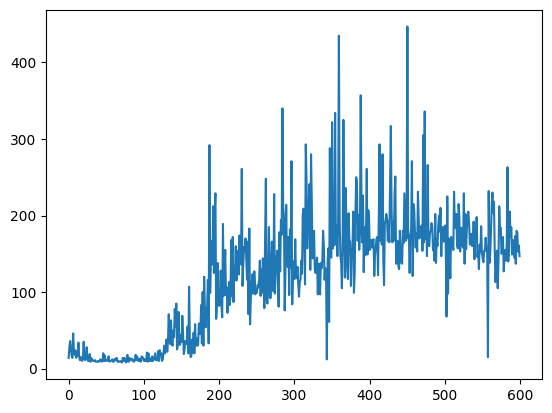

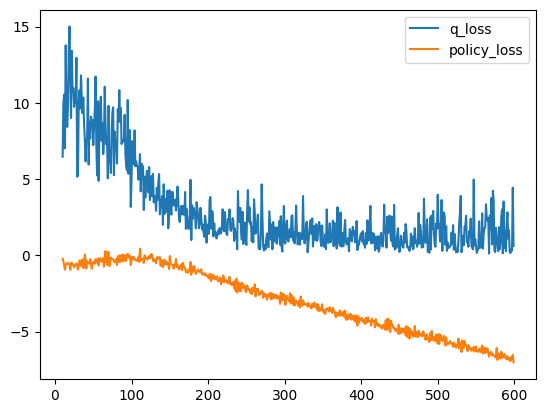

In [15]:
plot(env_steps)
figure()
plot([x[0] for x in env_losses])
plot([x[1] for x in env_losses])
plt.legend(["q_loss", "policy_loss"])